## Daniel Barella
## 10/6/25

# 🧠 Day 32 – Feature Engineering Deep Dive  
**Repo 4: From ML to AI**

Yesterday we learned *how* models learn (via optimization).  
Today, we learn *what* they learn from — the **features**.  

Feature engineering is the art and science of transforming raw data into something machine learning models can actually use effectively.

---

## 🎯 Learning Objectives
By the end of this lesson, you’ll be able to:
- Detect and handle **outliers**  
- Manage **skewed data distributions**  
- Apply **log, box-cox, and power transformations**  
- Encode categorical variables smartly  
- Scale and normalize data  
- Build pipelines for repeatable preprocessing

---

## 🧩 1. Setup and Data Loading
We'll use the **California Housing dataset** from Scikit-learn for real-world-style feature transformations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
df = housing.frame
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


---

## 🧮 2. Exploring Data Distribution
Let’s look for skewness and outliers in numeric features.


In [2]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


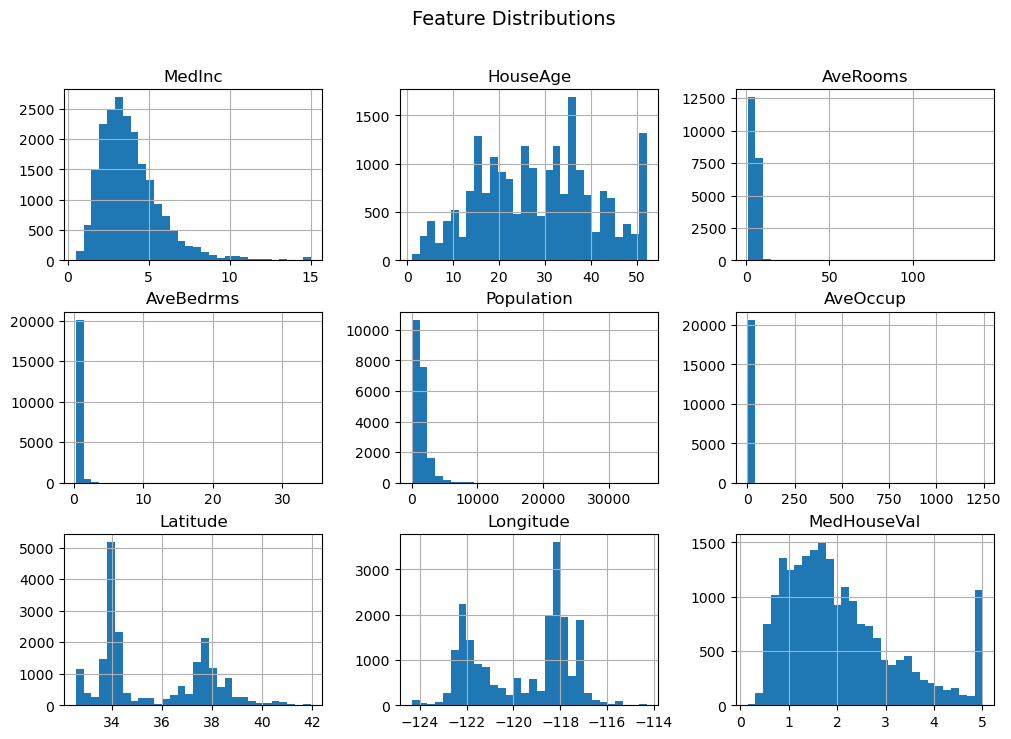

In [3]:
# Quick histogram overview
df.hist(bins=30, figsize=(12, 8))
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()


---

## ⚠️ 3. Handling Outliers

Let’s define a reusable function to detect and cap outliers using the **IQR (Interquartile Range)** method.


In [4]:
def cap_outliers(df, col):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, np.where(df[col] > upper, upper, df[col]))
    return df

for col in df.select_dtypes(include=np.number).columns:
    df = cap_outliers(df, col)


---

## 🔄 4. Fixing Skewed Data

Some features are heavily skewed — let’s normalize them using **log transformation**.


In [5]:
skewed = df.skew().sort_values(ascending=False)
skewed_features = skewed[abs(skewed) > 0.75].index
print("Skewed features:", list(skewed_features))

for col in skewed_features:
    df[col] = np.log1p(df[col])


Skewed features: ['MedHouseVal', 'Population']


---

## ⚙️ 5. Feature Scaling

To help models converge efficiently, we standardize our features (mean=0, std=1).


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled, columns=df.columns)
df_scaled.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.541006,0.982143,1.347665,-0.424488,-1.756114,-0.497871,1.052548,-1.327835,1.853931
1,2.541006,-0.607019,0.749027,-1.070004,1.112574,-1.142781,1.043185,-1.322844,1.325400
2,2.085156,1.856182,2.394098,0.192534,-1.139974,-0.140910,1.038503,-1.332827,1.285601
3,1.111288,1.856182,0.411358,0.187723,-0.971892,-0.508882,1.038503,-1.337818,1.217144
4,0.027262,1.856182,0.784108,0.287439,-0.954099,-1.039145,1.038503,-1.337818,1.222912


---

## 🧠 6. Encoding Categorical Data

Our current dataset is numeric, but let’s simulate encoding with a categorical example for practice.


In [7]:
cat_df = pd.DataFrame({
    'Neighborhood': ['A', 'B', 'C', 'A', 'B', 'C'],
    'Price': [120, 150, 200, 130, 160, 210]
})

encoded = pd.get_dummies(cat_df, drop_first=True)
encoded


,Price,Neighborhood_B,Neighborhood_C
0,120,0,0
1,150,1,0
2,200,0,1
3,130,0,0
4,160,1,0
5,210,0,1


---

## 🧩 7. Building a Preprocessing Pipeline

Let’s combine all preprocessing steps into one clean pipeline using Scikit-Learn.


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_features = df.select_dtypes(include=np.number).columns
cat_features = []  # placeholder for future categorical data

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', OneHotEncoder(), cat_features)
])


---

## 🚀 Mini Project: Predicting California Housing Prices

### Objective
Use the **cleaned and engineered dataset** to build a predictive model.

### Steps
1. Split your processed dataset into train/test sets  
2. Fit a `LinearRegression` and `RandomForestRegressor`  
3. Compare performance (R² and RMSE)  
4. Visualize feature importances for the random forest  


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df_scaled.drop('MedHouseVal', axis=1)
y = df_scaled['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}:")
    print("R²:", round(r2_score(y_test, preds), 3))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test, preds)), 3))



Linear Regression:
R²: 0.681
RMSE: 0.564

Random Forest:
R²: 0.826
RMSE: 0.416


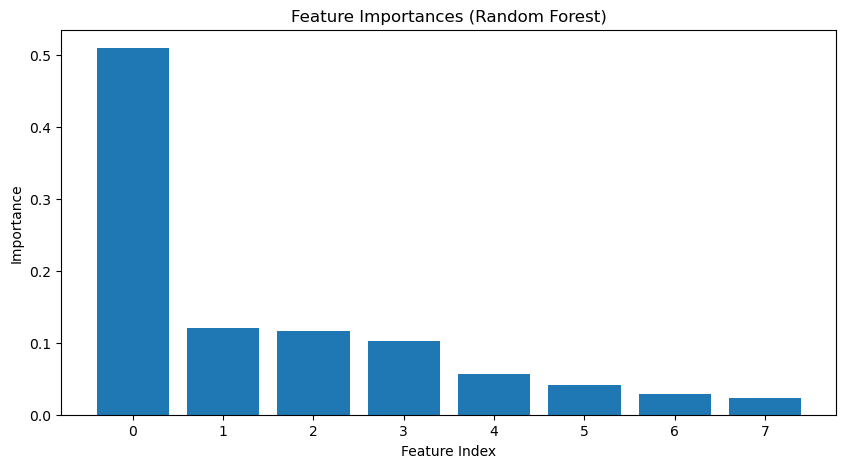

In [10]:
# Feature importance plot for Random Forest
rf = models["Random Forest"]
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.bar(range(X.shape[1]), importances[sorted_idx])
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


---

## 🧭 Reflection
- What transformations improved model performance the most?  
- How does scaling affect optimization and learning speed?  
- Why is log transformation helpful for skewed data?

---

### ✅ Key Takeaways
- Feature engineering can make or break a model’s success.  
- Scaling, encoding, and transformation improve model stability.  
- Pipelines help keep preprocessing organized and reproducible.  

---

**Next Up → [Day 33: Regularization (L1/L2/Ridge/Lasso)](../day33_regularization/day33_regularization.ipynb)**
